In [2]:
from lrgsglib.core import *
move_to_rootf()
#
giampiero_mat_path = Path('data') / 'real_data' / 'brain' / 'Pat_02'
#

Current working directory: /home/opisthofulax/Documents/PhD/projects/complex-networks/lrgsglib


In [3]:
ch_names = loadmat(giampiero_mat_path / 'ChannelNames.mat')
ch_names_list = [name[0] for name in ch_names["ChannelNames"][0]]
nodemap = {i: ch_names_list[i] for i in range(len(ch_names_list))}

In [4]:
pretask_ts = loadmat(giampiero_mat_path / 'Resting_PreTask_Data.mat')
pretask_ts.keys(), type(pretask_ts['Data']), pretask_ts['Data'].shape

(dict_keys(['__header__', '__version__', '__globals__', 'Data', 'Parameters', 'None', '__function_workspace__']),
 numpy.ndarray,
 (117, 1323208))

### Data format

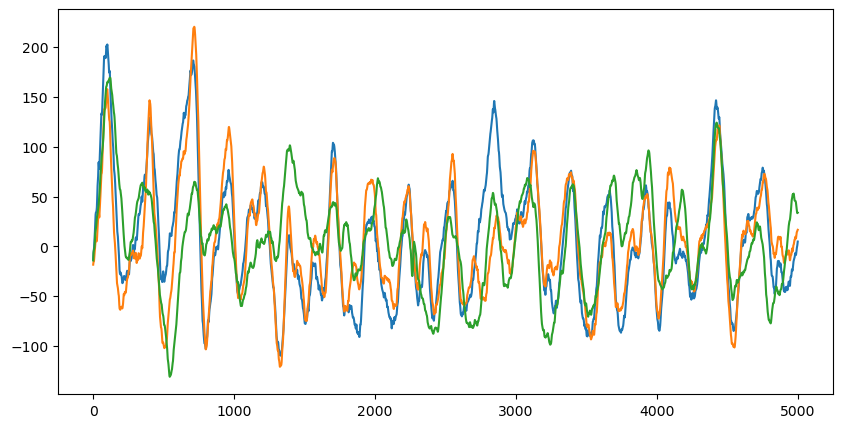

In [29]:
tstop = 5000
#
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#
ax.plot(pretask_ts['Data'][0, :tstop])
ax.plot(pretask_ts['Data'][1, :tstop])
ax.plot(pretask_ts['Data'][-1, :tstop])

### Marchenko–Pastur distribution
The probability mass of the Marchenko–Pastur distribution is bounded for correlation matrices over the interval defined by
$$\lambda_{\pm} = \left(1 \pm \sqrt{\frac N t}\right)^2$$
thus in the large time-observation limit $t\to\infty$ of $N$ timeseries its a delta at $\lambda=1$.

In [30]:
threshold = 0.
filttime = 50

In [35]:
data = pretask_ts['Data']
datafilt = pretask_ts['Data'][:, :filttime]
#
C = np.corrcoef(data)
#
Cdiff = np.corrcoef(np.diff(data))
tsteps = data.shape[1]
gamma = data.shape[0]/tsteps
#
Cdiff_filt = np.corrcoef(np.diff(datafilt))
tstepsf = datafilt.shape[1]
gammaf = datafilt.shape[0]/tstepsf
#
Cspect = np.linalg.eigvals(C)
Cdiffspect = np.linalg.eigvals(Cdiff)
Cdiffspect_filt = np.linalg.eigvals(Cdiff_filt)

/home/opisthofulax/anaconda3/envs/lrgsgenv/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/opisthofulax/anaconda3/envs/lrgsgenv/lib/python3.12/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/opisthofulax/anaconda3/envs/lrgsgenv/lib/python3.12/site-packages/numpy/lib/histograms.py:884: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/home/opisthofulax/anaconda3/envs/lrgsgenv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6865: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


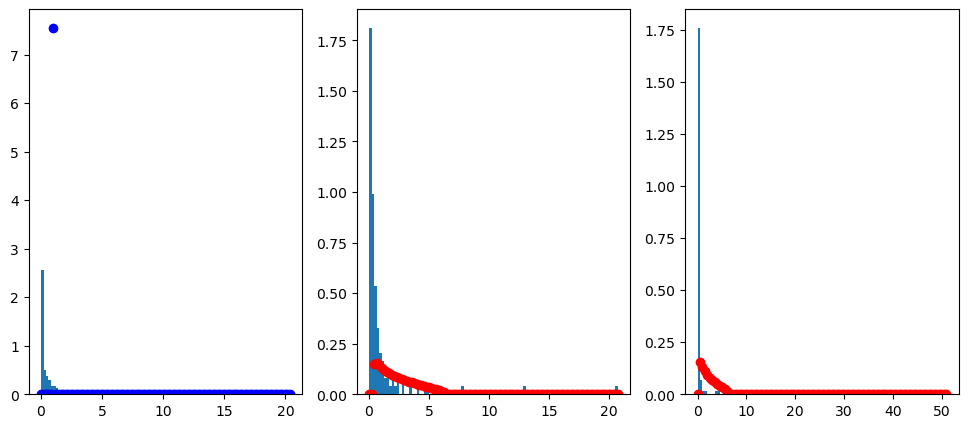

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
#
y, x, im = ax[0].hist(Cspect, density=True, bins=100)
marchpast = marchenko_pastur(x, gamma)
ax[0].plot(x, marchpast, 'bo')
y, x, im = ax[1].hist(Cdiffspect, density=True, bins=100)
marchpast = marchenko_pastur(x, gammaf)
ax[1].plot(x, marchpast, 'ro')
y, x, im = ax[2].hist(Cdiffspect_filt, density=True, bins=100)
marchpast = marchenko_pastur(x, gammaf)
ax[2].plot(x, marchpast, 'ro')

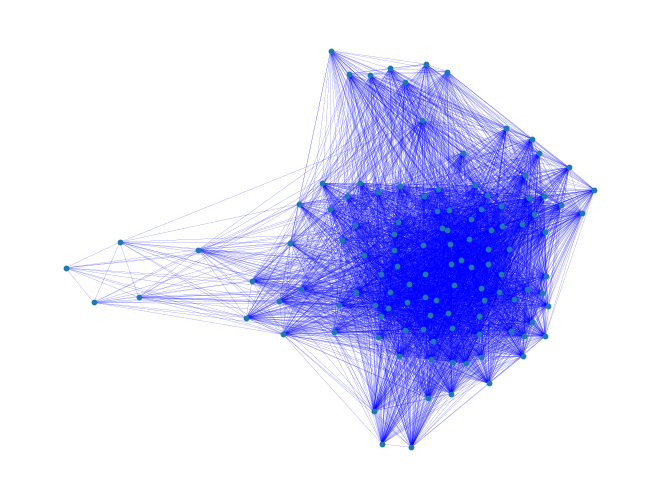

In [8]:
G = nx.from_numpy_array(C)
edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G.edges(data=True)]
nx.draw(G, node_size=10, width=0.1, edge_color=edge_colors)

### Thresholding protocol
The protocol is based on the idea that a dense weighted graph (e.g., a correlation matrix) can be sparsified by removing the weakest connections while preserving its overall connectivity. The main steps are as follows:
1. **Extract the Giant Component:**  
   Given a graph $G$ with weighted edges $w_{ij} > 0$, remove all self-loops and extract the giant component $G_0$. If $N_0$ is the total number of nodes in $G_0$, then this forms the reference set for our analysis.

2. **Define Thresholded Graphs:**  
   For a given threshold $t$, construct a subgraph $G(t)$ from $G_0$ by removing all edges with weights below $t$:
   $$
   G(t) = \{(i,j) \in G_0 \mid w_{ij} \ge t\}
   $$
   The goal is to find a $t$ such that the network starts fragmenting, meaning that $G(t)$ loses a significant portion of its connectivity.

3. **Connectivity Metrics:**  
   For each threshold $t$, compute:
   - $ N_{\text{giant}}(t) $: the number of nodes in the largest connected component of $G(t)$.
   - $ E_{\text{giant}}(t) $: the number of edges in the largest connected component of $G(t)$.

   Then define the fractions:
   $$
   P_\infty(t) = \frac{N_{\text{giant}}(t)}{N_0}, \quad E_\infty(t) = \frac{E_{\text{giant}}(t)}{E_0}
   $$
   where $E_0$ is the total number of edges in $G_0$. When $t$ is very low, nearly all edges are retained and $P_\infty(t) \approx 1$ and $E_\infty(t) \approx 1$. As $t$ increases, weaker edges are pruned, and these fractions begin to drop—signaling a percolation-like transition.

4. **Optimal Threshold Selection:**  
   The protocol samples a range of threshold values $ \{ t_1, t_2, \dots, t_n \} $ (typically spaced logarithmically to capture variations across orders of magnitude). The optimal threshold $t^*$ is defined as the smallest $t$ for which
   $$
   P_\infty(t) < p,
   $$
   where $p$ is a chosen percentage (e.g., 0.9). This indicates that once the giant component loses more than $10\%$ of its nodes, the network starts fragmenting. The threshold $t^*$ is then used to remove edges in $G_0$ to yield a sparsified graph $G(t^*)$.

5. **Final Outcome:**  
   The final graph $G(t^*)$ is the thresholded (and thus sparser) version of the original giant component. It retains the strongest connections that keep the network connected up to the point of fragmentation.

This approach is similar to a percolation transition in network theory, where the order parameter (here $P_\infty(t)$) sharply decreases as the system passes through a critical threshold. By choosing $t^*$ at the onset of this transition, one removes noise or spurious correlations while preserving the network's core structure.


In [9]:
data = pretask_ts['Data']
#
C = np.corrcoef(data)
np.fill_diagonal(C, 0)
C[C < 0] = 0
G = nx.from_numpy_array(C)
G0 = get_giant_component(G)
Th, Einf, Pinf = compute_threshold_stats(G0)

Computing threshold stats: 100%|██████████| 400/400 [00:07<00:00, 51.06it/s]


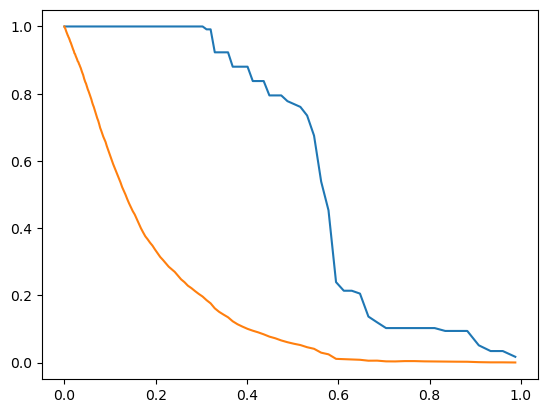

In [10]:
plt.plot(Th, Pinf)
plt.plot(Th, Einf)

In [23]:
best_th = 0.3

In [12]:
C_th = C.copy()
C_th[C < best_th] = 0
G0 = nx.from_numpy_array(C_th)
G0, removednodes = get_giant_component_leftoff(G0)
removednodes

[]

In [13]:
#
PreTaskThEntropy = entropy(G0, t1=-3, t2=5, steps=400)
tau_scale = PreTaskThEntropy[-1]
speC = PreTaskThEntropy[1]/PreTaskThEntropy[1].max()
Sm1 = PreTaskThEntropy[0]/PreTaskThEntropy[0].max()
#
print("Best threshold: ", best_th)

Best threshold:  0.3


/home/opisthofulax/Documents/PhD/projects/complex-networks/lrgsglib/src/lrgsglib/core.py:645: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/PhD/projects/complex-networks/lrgsglib/src/lrgsglib/core.py:645: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


In [14]:
spectrum, L, rho, Trho, tau = compute_laplacian_properties(G0, tau=None)
dists = squareform(Trho)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G0, method='ward')
FlatClusteringTh , *_ = compute_optimal_threshold(linkage_matrix)

In [15]:
FlatClusteringTh =1e-8
optimal_clusters = fcluster(linkage_matrix, t=FlatClusteringTh, criterion='distance')

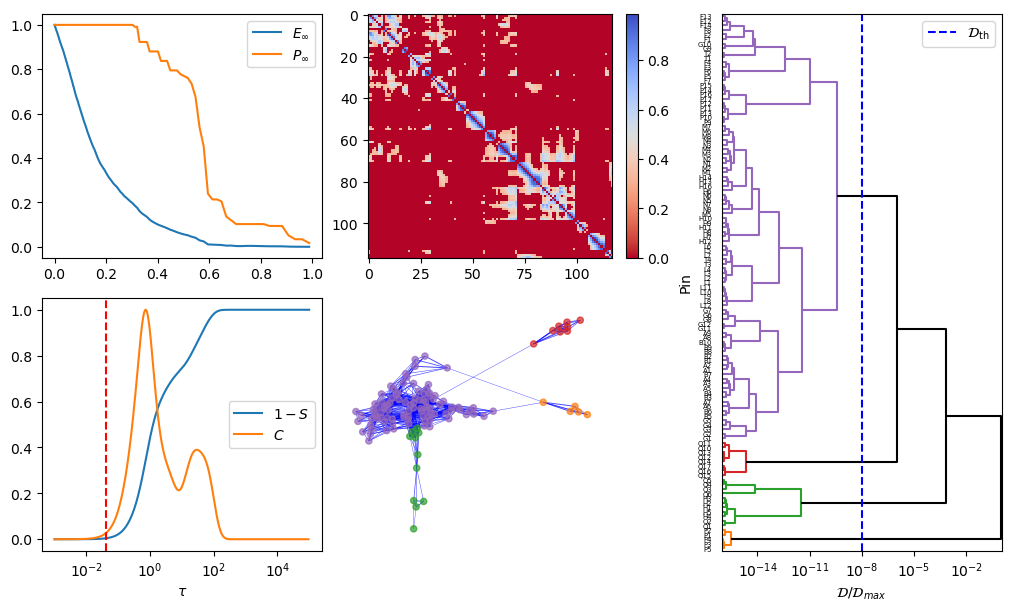

In [16]:
fig = plt.figure(constrained_layout=True,figsize=(10,6))
#
ax_dict = fig.subplot_mosaic(
    """
    AABBEE
    AABBEE
    CCDDEE
    CCDDEE
    """
)
#
ax_dict['A'].plot(Th, Einf, label=r"$E_{\infty}$")
ax_dict['A'].plot(Th, Pinf, label=r"$P_{\infty}$")
ax_dict['A'].legend()
#
im = ax_dict['B'].imshow(C_th, cmap='coolwarm_r', interpolation='none')
#
ax_dict['C'].plot(tau_scale, Sm1, label=r'$1-S$')
ax_dict['C'].plot(tau_scale[:-1], speC, label=r'$C$')
ax_dict['C'].set_xscale('log')
ax_dict['C'].legend()
ax_dict['C'].set_xlabel(r"$\tau$")
ax_dict['C'].axvline(tau, color = 'r', 
    linestyle = '--', )
#
relabel_list = [nodemap[nd] for nd in label_list]
dendro = dendrogram(linkage_matrix, ax=ax_dict['E'], 
                    color_threshold=FlatClusteringTh,
    above_threshold_color='k',
    labels=relabel_list, orientation='right')
tmin = linkage_matrix[::, 2][0] - 0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1] + 0.1*linkage_matrix[::, 2][-1]
#
ax_dict['E'].axvline(
    FlatClusteringTh, 
    color = 'b', 
    linestyle = '--', 
    label=r"$\mathcal{D}_{\rm th}$")
ax_dict['E'].set_xscale('log')
ax_dict['E'].set_xlim(tmin,tmax)
ax_dict['E'].legend()
ax_dict['E'].set_xlabel(r"$\mathcal{D}/\mathcal{D}_{max}$")
ax_dict['E'].set_ylabel('Pin')
#
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[label] for label in relabel_list]
edge_weights = np.array([G0[u][v].get("weight", 1.0) for u, v in G0.edges()])
edge_widths = 0.3 + 0.5 * (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min() + 1e-6)
edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G0.edges(data=True)]
pos = nx.spring_layout(G0, seed=5)

#
nx.draw(G0, pos=pos, ax=ax_dict['D'], node_size=20, width=edge_widths, edge_color=edge_colors, node_color=node_colors,alpha=0.7)
# plt.margins(0.0)
#
fig.colorbar(im, ax=ax_dict['B'])

### Correlation Matrices at successive steps

In [24]:
timesteps = data.shape[1]
batch_number = 10
batch_size = timesteps // batch_number
batch_an_data = data[:, :timesteps]
print(batch_size)

132320


In [25]:
corr_list = []
for i in range(batch_number):
    batch = batch_an_data[:, :(i+1)*batch_size]
    Ctmp = np.corrcoef(batch)
    np.fill_diagonal(Ctmp, 0)
    Ctmp[Ctmp < best_th] = 0
    corr_list.append(Ctmp)

/tmp/ipykernel_4199/3372659142.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', batch_number)  # Choose a colormap (e.g., 'viridis')
10it [00:01,  9.47it/s]


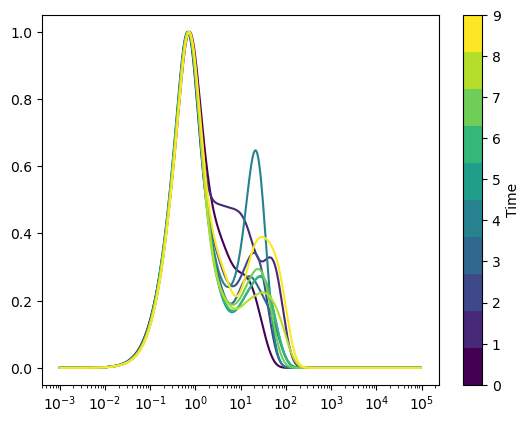

In [27]:
cmap = plt.cm.get_cmap('viridis', batch_number)  # Choose a colormap (e.g., 'viridis')
norm = Normalize(vmin=0, vmax=batch_number - 1)  # Normalize for color mapping

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for colorbar
Clist = []
for i,cc in tqdm(enumerate(corr_list)):
    G = nx.from_numpy_array(cc)
    PreTaskThEntropy = entropy(G, t1=-3, t2=5, steps=400)
    tau_scale = PreTaskThEntropy[-1]
    color = cmap(i)
    speC = PreTaskThEntropy[1]/PreTaskThEntropy[1].max()
    plt.plot(tau_scale[:-1], speC, label=r'$C$', color=color)
    Clist.append(speC)
# plt.plot(tau_scale[:-1], np.mean(Clist, axis=0), label=r'$C$', color='black', zorder=101)
# plt.fill_between(tau_scale[:-1], 
#                  np.maximum(0, np.mean(Clist, axis=0) - np.std(Clist, axis=0)), 
#                  np.maximum(0, np.mean(Clist, axis=0) + np.std(Clist, axis=0)), 
#                  color='gray', alpha=0.5, zorder=100)
plt.xscale('log')
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Time')

### State decomposition

In [20]:
brain_net = SignedGraph(G0)
brain_net.compute_full_laplacian_spectrum()

In [21]:
time_an = 10
state_time = data[:,time_an]

In [22]:
dist = []
for i in range(1, brain_net.N):
    basis = [np.array(eigV).squeeze() for eigV in brain_net.eigV[:i, :]]
    proj = matrix_projection(state_time, basis)
    recon = reconstruct_from_projections(proj, basis)
    dist.append(np.linalg.norm(state_time-recon)/np.linalg.norm(state_time))

Indices where large jumps occur: [  1   2   3   4   5   6   7   8   9  10  12  14  15  18  19  21  22  25
  26  27  28  29  30  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  50  52  53  55  57  59  61  62  66  69  70  71  73  74  75
  76  77  78  79  81  82  83  84  85  86  88  91  93  94  95  96  98  99
 100 101 102 103 104 105 106 107 108 109 110 112 113 114]


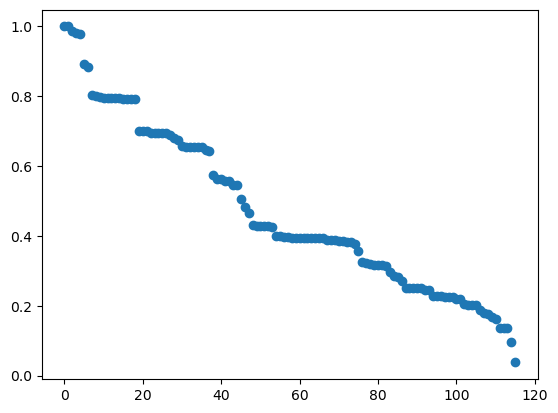

In [23]:
plt.plot(dist, 'o')
diffs = np.diff(dist)
# Define a threshold: mean plus two times the standard deviation
threshold_value = np.mean(diffs) + .5 * np.std(diffs)
# Find indices where the difference exceeds the threshold.
# Note: the index refers to the jump between element i and i+1.
jump_indices = np.where(np.abs(diffs) > threshold_value)[0]
print("Indices where large jumps occur:", jump_indices)

In [24]:
basis = [np.array(brain_net.eigV[i, :]).squeeze() for i in jump_indices]
proj = matrix_projection(state_time, basis)
recon = reconstruct_from_projections(proj, basis)

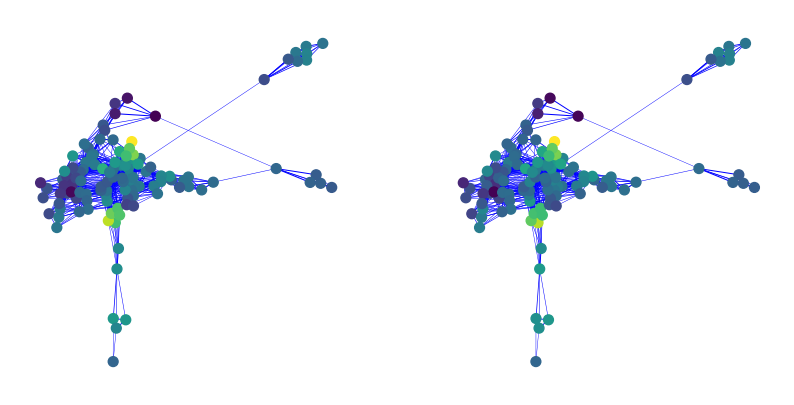

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
nx.draw(G0, pos=pos, ax=ax[0], node_size=50, width=edge_widths, edge_color=edge_colors, node_color=state_time/np.linalg.norm(state_time),)
nx.draw(G0, pos=pos, ax=ax[1], node_size=50, width=edge_widths, edge_color=edge_colors, node_color=recon/np.linalg.norm(recon),)

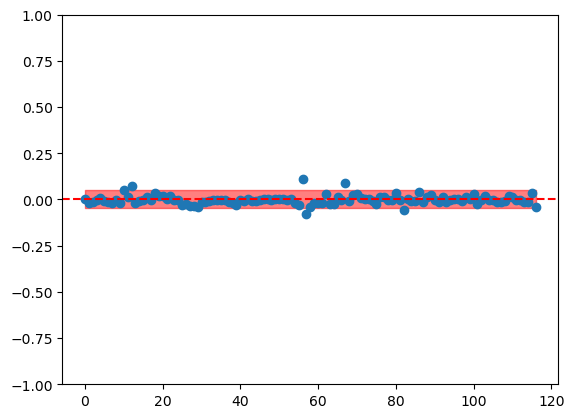

In [26]:
differ = recon/np.linalg.norm(recon)-state_time/np.linalg.norm(state_time)
plt.plot(differ, 'o')
plt.ylim(-1, 1)
plt.axhline(0, color='r', linestyle='--')
plt.fill_between(np.arange(0, brain_net.N), -2*np.std(differ), 2*np.std(differ), color='r', alpha=0.5)